<a href="https://colab.research.google.com/github/POPE001/Fraud-Detection/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE


In [ ]:
class FraudDetectionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(FraudDetectionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class FraudDataset(Dataset):
    def __init__(self, data):
        self.features = data[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].values.astype(float)
        self.labels = data['isFraud'].values.astype(float)

        # Data scaling
        scaler = StandardScaler()
        self.features = scaler.fit_transform(self.features)

        # Data oversampling
        oversampler = RandomOverSampler(random_state=42)
        self.features, self.labels = oversampler.fit_resample(self.features, self.labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(features).unsqueeze(0), torch.tensor(label)  # Reshape features to add an additional dimension


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.listdir('/content')


['.config', 'drive', 'crime_data', 'sample_data']

In [ ]:
# Load and preprocess the dataset
df = pd.read_csv('/content/crime_data')

In [ ]:
# Define the features and target variable
X = df.drop(["isFraud"], axis=1)
y = df["isFraud"]

In [ ]:

# Remove rows with missing values
df.dropna(inplace=True)

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("Duplicates:", duplicates)

Duplicates: 0


In [ ]:
# Removing duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Check the number of rows and columns
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 821056
Number of columns: 11


In [ ]:
# Save the cleaned dataset
df.to_csv('cleaned_fraud_dataset.csv', index=False)

In [ ]:
# Load the cleaned dataset



In [ ]:
dataset = FraudDataset(df)


In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [ ]:
# Set batch size and create the data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Create the model and optimizer
input_size = 10
hidden_size = 64
num_layers = 2
num_classes = 2

In [ ]:
# Create the model and optimizer
model = FraudDetectionRNN(input_size, hidden_size, num_layers, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Test data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Validation data loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_losses = []
val_losses = []
num_epochs = 10
best_val_f1 = 0.0
best_model_state = None  # Initialize the best model state

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    val_preds = []
    val_labels = []

    # Training
    model.train()
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_features = batch_features.to(device, dtype=torch.float32)
        batch_labels = batch_labels.to(device, dtype=torch.float32)[:, None]
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)

    # Validation
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features = batch_features.to(device, dtype=torch.float32)
            batch_labels = batch_labels.to(device, dtype=torch.float32)[:, None]
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item() * batch_features.size(0)
            val_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
            val_labels.extend(batch_labels.cpu().detach().numpy())

    # Calculate metrics
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_preds = np.where(val_preds >= 0.5, 1, 0)  # Apply threshold of 0.5 for classification

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    val_roc_auc = roc_auc_score(val_labels, val_preds)

    # Append losses to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1-Score: {val_f1:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()

Epoch [1/10], Train Loss: 0.1127, Val Loss: 0.1074
Val Accuracy: 0.9466, Val Precision: 0.9700, Val Recall: 0.9216, Val F1-Score: 0.9452, Val ROC-AUC: 0.9466
Epoch [2/10], Train Loss: 0.1102, Val Loss: 0.0990
Val Accuracy: 0.9615, Val Precision: 0.9618, Val Recall: 0.9611, Val F1-Score: 0.9614, Val ROC-AUC: 0.9615
Epoch [3/10], Train Loss: 0.1079, Val Loss: 0.1020
Val Accuracy: 0.9621, Val Precision: 0.9398, Val Recall: 0.9873, Val F1-Score: 0.9630, Val ROC-AUC: 0.9621
Epoch [4/10], Train Loss: 0.1056, Val Loss: 0.1008
Val Accuracy: 0.9615, Val Precision: 0.9498, Val Recall: 0.9745, Val F1-Score: 0.9620, Val ROC-AUC: 0.9615
Epoch [5/10], Train Loss: 0.1034, Val Loss: 0.0924
Val Accuracy: 0.9660, Val Precision: 0.9588, Val Recall: 0.9737, Val F1-Score: 0.9662, Val ROC-AUC: 0.9660
Epoch [6/10], Train Loss: 0.1015, Val Loss: 0.1010
Val Accuracy: 0.9644, Val Precision: 0.9387, Val Recall: 0.9935, Val F1-Score: 0.9654, Val ROC-AUC: 0.9644
Epoch [7/10], Train Loss: 0.0994, Val Loss: 0.0911
V

In [ ]:
X_test = X_test.drop('nameDest', axis=1)


In [ ]:
X_train = X_train.drop('nameOrig', axis=1)

In [ ]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# Scale the test features using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)


In [ ]:
batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Evaluate the best model on the test set
model.load_state_dict(best_model_state)
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device).float()
        batch_labels = batch_labels.float().view(-1, 1).to(device)

        outputs = model(batch_features)
        predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy().flatten()
        targets = batch_labels.cpu().numpy().flatten()

        test_predictions.extend(predictions)
        test_targets.extend(targets)

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

test_accuracy = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions)
test_f1 = f1_score(test_targets, test_predictions)
test_roc_auc = roc_auc_score(test_targets, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')


Test Accuracy: 0.9518
Test Precision: 0.9692
Test F1-Score: 0.9510
Test ROC AUC: 0.9518


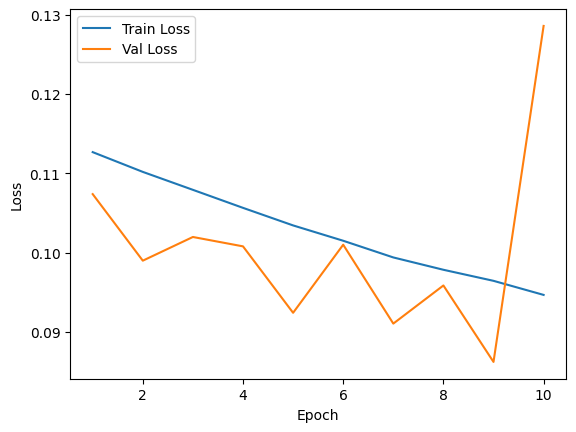

In [ ]:
# Plot the training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


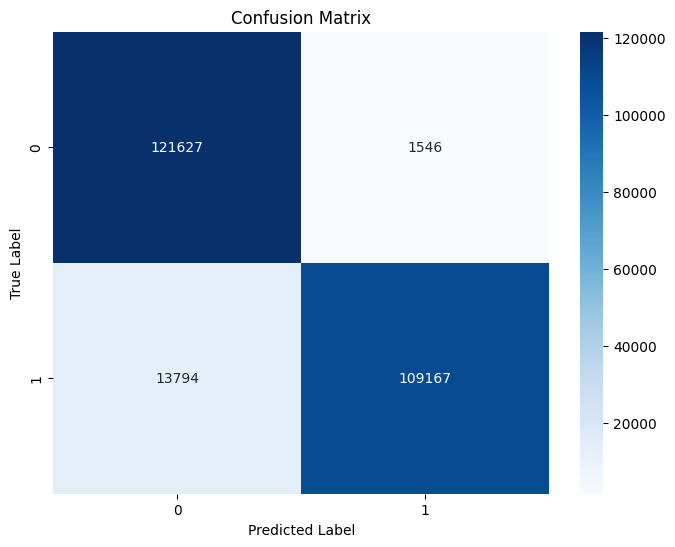

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_mat = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# Remove rows with missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Update the target variable accordingly

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer with the desired strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform the training data
X_train_imputed = imputer.fit_transform(X_train)

# Continue with training the LogisticRegression model using the imputed data
logistic_regression.fit(X_train_imputed, y_train)


LogisticRegression()

In [ ]:
# Train benchmark models
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()

logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Predict using benchmark models
logistic_regression_preds = logistic_regression.predict(X_test)
random_forest_preds = random_forest.predict(X_test)

# Evaluate benchmark models
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_preds)
random_forest_accuracy = accuracy_score(y_test, random_forest_preds)

logistic_regression_precision = precision_score(y_test, logistic_regression_preds)
random_forest_precision = precision_score(y_test, random_forest_preds)

logistic_regression_recall = recall_score(y_test, logistic_regression_preds)
random_forest_recall = recall_score(y_test, random_forest_preds)

logistic_regression_f1_score = f1_score(y_test, logistic_regression_preds)
random_forest_f1_score = f1_score(y_test, random_forest_preds)

logistic_regression_roc_auc = roc_auc_score(y_test, logistic_regression_preds)
random_forest_roc_auc = roc_auc_score(y_test, random_forest_preds)


In [ ]:
# Print the evaluation results
print("Benchmark Model Performance:")
print("Logistic Regression:")
print(f"Accuracy: {logistic_regression_accuracy:.4f}")
print(f"Precision: {logistic_regression_precision:.4f}")
print(f"Recall: {logistic_regression_recall:.4f}")
print(f"F1-Score: {logistic_regression_f1_score:.4f}")
print(f"ROC AUC: {logistic_regression_roc_auc:.4f}")

Benchmark Model Performance:
Logistic Regression:
Accuracy: 0.9965
Precision: 0.4000
Recall: 0.1053
F1-Score: 0.1667
ROC AUC: 0.5524


In [ ]:
print("Random Forest:")
print(f"Accuracy: {random_forest_accuracy:.4f}")
print(f"Precision: {random_forest_precision:.4f}")
print(f"Recall: {random_forest_recall:.4f}")
print(f"F1-Score: {random_forest_f1_score:.4f}")
print(f"ROC AUC: {random_forest_roc_auc:.4f}")

Random Forest:
Accuracy: 0.9977
Precision: 1.0000
Recall: 0.3158
F1-Score: 0.4800
ROC AUC: 0.6579


In [ ]:
input_size = 5  # Number of features in your data
hidden_size = 32
num_layers = 2


In [ ]:
X_train = X_train[:, :5]
X_test = X_test[:, :5]


In [ ]:
import tensorflow as tf
from keras.models import Sequential

# Create the MLP model with the modified input shape
mlp_model = Sequential()
mlp_model.add(Dense(16, activation='relu', input_shape=(5,)))
mlp_model.add(Dense(8, activation='relu'))
mlp_model.add(Dense(1, activation='sigmoid'))



In [ ]:
# Define the CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Convert the input data to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
column_index = 3


In [ ]:
X_train = np.delete(X_train, column_index, axis=1)

In [ ]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [ ]:
# Define the RNN model

rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=100, output_dim=16, input_length=X_train.shape[1]),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Define the LSTM model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=100, output_dim=16, input_length=X_train.shape[1]),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:

# Compile and train the models
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
# Evaluate the models
mlp_predictions = mlp_model.predict(X_test)
cnn_predictions = cnn_model.predict(X_test)
rnn_predictions = rnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

mlp_probs = mlp_predictions.flatten()
cnn_probs = cnn_predictions.flatten()
rnn_probs = rnn_predictions.flatten()
lstm_probs = lstm_predictions.flatten()

mlp_pred_labels = np.round(mlp_probs)
cnn_pred_labels = np.round(cnn_probs)
rnn_pred_labels = np.round(rnn_probs)
lstm_pred_labels = np.round(lstm_probs)

mlp_accuracy = accuracy_score(y_test, mlp_pred_labels)
cnn_accuracy = accuracy_score(y_test, cnn_pred_labels)
rnn_accuracy = accuracy_score(y_test, rnn_pred_labels)
lstm_accuracy = accuracy_score(y_test, lstm_pred_labels)

mlp_precision = precision_score(y_test, mlp_pred_labels)
cnn_precision = precision_score(y_test, cnn_pred_labels)
rnn_precision = precision_score(y_test, rnn_pred_labels)
lstm_precision = precision_score(y_test, lstm_pred_labels)

mlp_recall = recall_score(y_test, mlp_pred_labels)
cnn_recall = recall_score(y_test, cnn_pred_labels)
rnn_recall = recall_score(y_test, rnn_pred_labels)
lstm_recall = recall_score(y_test, lstm_pred_labels)

mlp_f1_score = f1_score(y_test, mlp_pred_labels)
cnn_f1_score = f1_score(y_test, cnn_pred_labels)
rnn_f1_score = f1_score(y_test, rnn_pred_labels)
lstm_f1_score = f1_score(y_test, lstm_pred_labels)

mlp_roc_auc = roc_auc_score(y_test, mlp_probs)
cnn_roc_auc = roc_auc_score(y_test, cnn_probs)
rnn_roc_auc = roc_auc_score(y_test, rnn_probs)
lstm_roc_auc = roc_auc_score(y_test, lstm_probs)

# Compare the results
models = ['MLP', 'CNN', 'RNN', 'LSTM']
accuracies = [mlp_accuracy, cnn_accuracy, rnn_accuracy, lstm_accuracy]
precisions = [mlp_precision, cnn_precision, rnn_precision, lstm_precision]
recalls = [mlp_recall, cnn_recall, rnn_recall, lstm_recall]
f1_scores = [mlp_f1_score, cnn_f1_score, rnn_f1_score, lstm_f1_score]
roc_aucs = [mlp_roc_auc, cnn_roc_auc, rnn_roc_auc, lstm_roc_auc]

results_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies, 'Precision': precisions,
                           'Recall': recalls, 'F1-Score': f1_scores, 'ROC AUC': roc_aucs})
print(results_df)